In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json

In [2]:
from src import irrigation_db
from importlib import reload
reload(irrigation_db);
from src.irrigation_db import DB

In [7]:
##creating the database from the irrigation data downloaded from the USDA, and the state abbreviation 
d = DB('data/irrigation.db', create=True) 

In [59]:
#if database is already made:
d = DB('data/irrigation.db')

In [8]:
d.build_tables()

In [9]:
d.load_data() #may take a couple minutes due to all the preprocessing

In [60]:
conn = sqlite3.connect('data/irrigation.db') #be sure to run conn.close() at the end
curs = conn.cursor()

* The functions below are to be put into a separate .py file
* I still have to incorporate a sqlite3.Connection parameter in any of them that use the object stored as conn, or make a run_query function that both opens and closes a connection to the database (which is what I'll likely do)

In [6]:
def get_commodity()->list[str]: 
    '''
    
    gets a list commodities a user can select from 

    '''
    
    
    sql="""
    SELECT DISTINCT commodity FROM tMain
    ;"""
    comms=pd.read_sql(sql, conn).values
    return comms

def get_domains(comm_params:dict[str,str])->list[str]: 
    '''
    gets the domains a user can pick (dependent on which commodity they chose)
    
    '''
    
    my_params = json.dumps(comm_params)
    sql="""
    SELECT DISTINCT domain FROM tMain
    WHERE commodity IN (SELECT value FROM json_tree(:params) WHERE path = '$.commodity')
    ;"""
    avail_doms=pd.read_sql(sql, conn, params={'params': my_params}).values
    return avail_doms

def get_data_items(dt_params:dict[str,str])->list[str]: 
    '''
    
    gets the data items a user can pick (dependent on the commodity and domain chosen)

    '''
    
    my_params = json.dumps(dt_params)
    sql = """
    SELECT DISTINCT data_item FROM tMain
    WHERE commodity IN (SELECT value FROM json_tree(:params) WHERE path = '$.commodity')
       AND domain IN (SELECT value FROM json_tree(:params) WHERE path = '$.domain')
    ;"""
    dat_items=pd.read_sql(sql, conn, params={'params': my_params}).values 
    return dat_items

def get_domain_categories(dc_params:dict[str,str])->list[str]: 
    '''
    gets possible domain categories the user can choose from 

    '''

    if dc_params['domain'] != ['TOTAL']: 
        my_params = json.dumps(dc_params)
        sql = """
        SELECT DISTINCT domain_category FROM tMain
        WHERE commodity IN (SELECT value FROM json_tree(:params) WHERE path = '$.commodity')
           AND domain IN (SELECT value FROM json_tree(:params) WHERE path = '$.domain')
           AND data_item IN (SELECT value FROM json_tree(:params) WHERE path = '$."data_item"')
        ;"""
        dom_c_items=pd.read_sql(sql, conn, params={'params': my_params}).values ##user can only choose 1
        return dom_c_items
    else: ##handle the case in which user picked 'TOTAL' as the domain
        number_dt=number_dt_question()
        if number_dt == 'one': ##if they only wanted to use one data item (and therefore compare across states or years)
            return
        else:
            new_dat_i=intermediate_domain_categories(dc_params) 
            #returns a list of other possible data_items to compare to that also have 'TOTAL' as their domain
            return new_dat_i

def number_dt_question() -> str:
    '''
    
    used in the even the user specified domain as 'TOTAL'
    We need to know whether the user only wants one data item to analyze (and therefore look at the relationships between states or years)
    or multiple data items

    Will likely turn into some sort of encoding function, called when a user clicks a button (Multiple or One)

    '''
    
    answer=input('multiple or one?')
    return answer

def intermediate_domain_categories(idc_params: dict[str,str])->list[str]:
    '''
    
    getting data items that match the units of the initial data item the user chose, and that also have 'TOTAL' listed 
    as their domain
    
    '''
    
    unit=idc_params['data_item'][0].split(' - ')[-1]
    temp_params=idc_params.copy()
    temp_params['more_data_items']=[unit]
    my_params = json.dumps(temp_params)
    sql = """
    SELECT DISTINCT data_item FROM tMain
    WHERE commodity IN (SELECT value FROM json_tree(:params) WHERE path = '$.commodity')
        AND domain IN (SELECT value FROM json_tree(:params) WHERE path = '$.domain')
        AND data_item NOT IN (SELECT value FROM json_tree(:params) WHERE path = '$."data_item"')
        AND data_item LIKE CONCAT('%', (SELECT value FROM json_tree(:params) WHERE path = '$."more_data_items"'))
    ;"""
    dat_c_items=pd.read_sql(sql, conn, params={'params': my_params}).values 
    return dat_c_items
    
def get_years(year_params:dict[str, str])-> list[str]:
    '''
    
    using a for loop and numpy arrays to determine which years are available to be analyzed depending on the state(s)
    and other parameters selected by the user

    '''
    
    stored_years=[]
    for i in year_params['state_id']:
        temp_params=year_params.copy()
        temp_params['state_id']=[i]
        my_params = json.dumps(temp_params)
        sql = """
        SELECT DISTINCT year FROM tMain
        WHERE commodity IN (SELECT value FROM json_tree(:params) WHERE path = '$.commodity')
           AND domain IN (SELECT value FROM json_tree(:params) WHERE path = '$.domain')
           AND data_item IN (SELECT value FROM json_tree(:params) WHERE path = '$."data_item"') --NEED DOUBLE QUOTES HERE
           AND state_id IN (SELECT value FROM json_tree(:params) WHERE path = '$."state_id"')
        ;"""
        if 'domain_category' in temp_params.keys(): 
            ##in the case the user selected "TOTAL" as the domain, and therefore not have any items for 'domain category'
            sql=sql[:-1]+"""AND domain_category IN (SELECT value FROM json_tree(:params) WHERE path = '$."domain_category"');"""
        avail_years=pd.read_sql(sql, conn, params={'params': my_params})['year'].values
        stored_years+=avail_years.tolist()
    stored_years_np=np.array(stored_years)
    unique_years=np.unique(stored_years_np)
    all_years= stored_years_np.tolist()
    unique_years=unique_years.tolist()
    return_yrs=[]
    for i in unique_years:
        if all_years.count(i) ==len(year_params['state_id']):
            return_yrs+=[[i]]
    return return_yrs

def which_statistic(user_click) -> str:
    '''
    
    in final tool, user will click a button with one of these keys as the label
    this will then return the corresponding SQL function 

    '''
    
    encoding={'Minimum':'MIN', 'Maximum':'MAX', 'Average': 'AVG', 'Sum':'SUM'}
    return encoding[user_click]

def check_if_time_barplot(params:dict[str,str]) -> str: 
    '''
    
    used to aid in the final_query and set_group_by functions, but in final version 
    will likely be some sort of encoding function called when a user clicks a button (States or Years)

    '''
    
    answer=input("are you comparing 'states' or 'years'?")
    return answer
    
def final_query(operation:str, params:dict[str,str], line_graph=False) -> str:
    ##making the final query to the database that gets a value using the aggregation method (max, min, avg, sum) 
    #chosen by the user ( it is named operation here)
    start="SELECT 1.*"+operation+"(value) from tMain"
    
    middle="""
    WHERE commodity IN (SELECT value FROM json_tree(:params) WHERE path = '$.commodity')
           AND domain IN (SELECT value FROM json_tree(:params) WHERE path = '$.domain')
           AND data_item IN (SELECT value FROM json_tree(:params) WHERE path = '$."data_item"') --NEED DOUBLE QUOTES HERE
           AND state_id IN (SELECT value FROM json_tree(:params) WHERE path = '$."state_id"')
           AND year IN (SELECT value FROM json_tree(:params) WHERE path = '$.year') 
    """
    if 'domain_category' in params.keys(): ##taking into account cases where user picked "TOTAL" as domain
        middle=middle+"""AND domain_category IN(SELECT value FROM json_tree(:params) WHERE path = '$."domain_category"')"""
    if line_graph:
        suffix="GROUP BY year;"
    else:
        if len(params['data_item'])==1:
            if 'domain_category' in params.keys(): 
                if len(params['domain_category'])==1:
                    group_by=set_group_by(params) ##need to then investigate whether we group by state or year
                else: #multiple domain_categories
                    group_by='domain_category' ##one data item (like expense measured in __) but have multiple domain_categories
            else: ##need to then investigate whether we group by state or year
                group_by=set_group_by(params)     
        else: ##multiple data items --> data item is along the x axis
            group_by='data_item'
    
        
        suffix="GROUP BY "+group_by+';'    
    new=start+middle+suffix
    return new     

def set_group_by(params:dict[str,str])->str:
    '''
    
    handles cases where we either have to group by state or year 

    '''

    ##multiple years and multiple states or 1 state and 1 year --> 
        ##need to know if user wants states or years on x-axis if they want a bar chart
    if ((len(params['year']) != 1) & (len(params['state_id']) != 1)) | ((len(params['year']) == 1) & (len(params['state_id']) == 1)):  
        check_x_axis=check_if_time_barplot(params) ##specifically asks if they want to compare states or years
        if check_x_axis=='years':
            group_by='year'
        else: # check_x_axis=='states:
            group_by='state_id'
    #multiple years and 1 state
    elif (len(params['year'])>1) & (len(params['state_id'])==1): 
        group_by='year'
    #last case is when only 1 year listed but multiple states
    else: 
        group_by='state_id'
    return group_by

def execute_final_query(query:str, params: dict[str,str]) -> list[float]:
    '''
    Queries the database for the values to be visualized or analyzed, called after final_query()

    '''

    
    my_params = json.dumps(params)
    results=pd.read_sql(query, conn,params={'params': my_params})
    return results.iloc[:,-1].values.tolist()


The below is a current walkthrough of my functions to retrieve data relating to groundwater use of states that utilize the Ogallala Aquifer. In my final project, these functions will be called in the background when a user clicks a button, checks a box in a checklist, or selects an option in a dropdown list. Whenever they perform these actions, a dictionary will be updated.


The necessary keys for this dictionary are 'state_id', 'commodity', 'domain', 'data item', 'domain_category', and 'year'. State_id is the only independent element of the dictionary, meaning its items do not depend on any other value stored in the dictionary. Thus, we currently have to set it ourselves. Whenever we set a value to one of the keys, the value must be stored in a 1 dimensional list or else the querying will not work. In the case of setting domain to ['TOTAL'], then running get_domain_categories(your_dictionary), and wanting to compare multiple data items rather than multiple states or years, you append to the current list by running test['data_item'] +=['insert_your_additional_data_item']

**You must run the functions above in the order below.**

In [7]:
test={'state_id': ['CO', 'KS', 'NE', 'OK', 'TX']}

In [8]:
get_commodity()

array([['ENERGY'],
       ['FACILITIES & EQUIPMENT'],
       ['LABOR'],
       ['PRACTICES'],
       ['PUMPS'],
       ['WATER'],
       ['WELLS']], dtype=object)

In [9]:
test['commodity']=['ENERGY']

In [10]:
get_domains(test)

array([['WATER SOURCE'],
       ['TOTAL'],
       ['EXPENSE']], dtype=object)

In [11]:
test['domain'] = ['WATER SOURCE']

In [12]:
get_data_items(test)

array([['(FOR HORTICULTURE ONLY), UNDER PROTECTION ONLY - EXPENSE, MEASURED IN $ / 10,000 SQ FT IRRIGATED'],
       ['(FOR HORTICULTURE), UNDER PROTECTION - SQ FT IRRIGATED'],
       ['DIESEL & BIODIESEL, (FOR HORTICULTURE), UNDER PROTECTION - SQ FT IRRIGATED'],
       ['ELECTRICITY, (FOR HORTICULTURE), UNDER PROTECTION - SQ FT IRRIGATED'],
       ['ELECTRICITY, IN THE OPEN ONLY - EXPENSE, MEASURED IN $ / ACRE IRRIGATED'],
       ['GASOLINE & ETHANOL BLENDS, IN THE OPEN - ACRES IRRIGATED'],
       ['GASOLINE & ETHANOL BLENDS, IN THE OPEN ONLY - EXPENSE, MEASURED IN $ / ACRE IRRIGATED'],
       ['IN THE OPEN - ACRES IRRIGATED'],
       ['IN THE OPEN ONLY - EXPENSE, MEASURED IN $ / ACRE IRRIGATED'],
       ['(FOR HORTICULTURE ONLY), IN THE OPEN ONLY - EXPENSE, MEASURED IN $ / ACRE IRRIGATED'],
       ['DIESEL & BIODIESEL, IN THE OPEN - ACRES IRRIGATED'],
       ['DIESEL & BIODIESEL, IN THE OPEN ONLY - EXPENSE, MEASURED IN $ / ACRE IRRIGATED'],
       ['ELECTRICITY, IN THE OPEN - ACRES IR

In [13]:
test['data_item']=['IN THE OPEN - ACRES IRRIGATED']

In [14]:
get_domain_categories(test)

array([['GROUND'],
       ['SURFACE']], dtype=object)

In [15]:
test['domain_category']=['GROUND']

In [16]:
get_years(test)

[['2013'], ['2018'], ['2023']]

In [17]:
test['year']=['2013','2018','2023']

In [18]:
test

{'state_id': ['CO', 'KS', 'NE', 'OK', 'TX'],
 'commodity': ['ENERGY'],
 'domain': ['WATER SOURCE'],
 'data_item': ['IN THE OPEN - ACRES IRRIGATED'],
 'domain_category': ['GROUND'],
 'year': ['2013', '2018', '2023']}

In [19]:
##arbitrarily choosing sum and having states as the x axis for a visualization
#be sure to type in 'states' (but without the quotation marks) when prompted
final_query_states=final_query('SUM',test)

are you comparing 'states' or 'years'? states


In [21]:
execute_final_query(final_query_states, test)

[3057718.0, 7541818.0, 22219897.0, 1432628.0, 10806057.0]

In [22]:
##arbitrarily choosing sum and having years as the x axis for a visualization
#be sure to type in 'years' (but without the quotation marks) when prompted
final_query_years=final_query('SUM',test)

are you comparing 'states' or 'years'? years


In [23]:
execute_final_query(final_query_years, test)

[16509423.0, 14736482.0, 13812213.0]

The below are simple example visualizations with some items hardcoded. In my final submission there will be generalized visualization functions depending on if the user specifed line graph or bar chart. These graphs and charts will be much more visually appealing than the ones you see below

In [24]:
import plotly
import plotly.express as px

In [25]:
by_state_vals=execute_final_query(final_query_states, test)

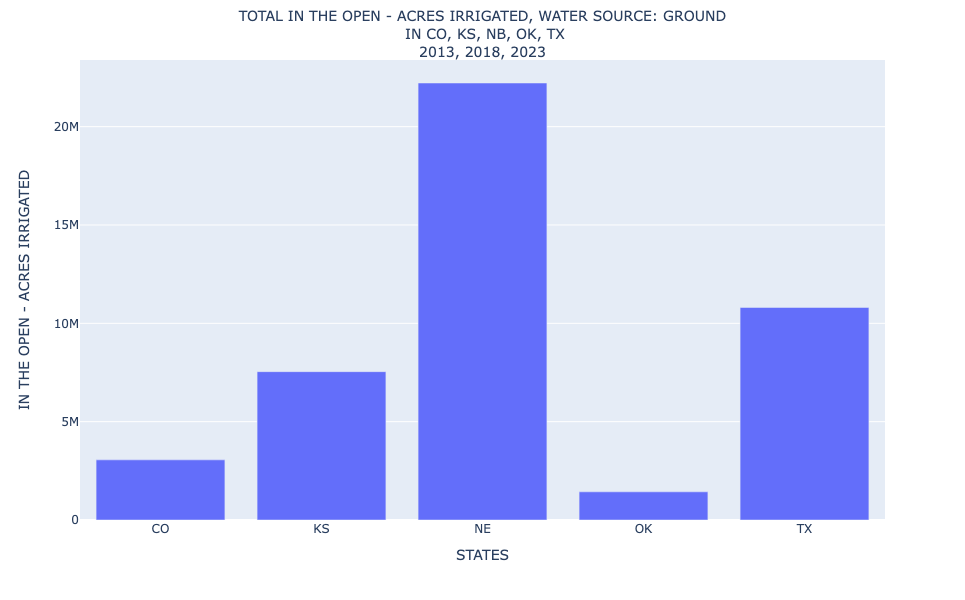

In [52]:
data={'state': test['state_id'], 'value': by_state_vals}
# Create a bar chart
fig = px.bar(data, x='state', y='value', width=850, height=600)

# Customizing the chart
fig.update_layout(
    title={'text': "TOTAL IN THE OPEN - ACRES IRRIGATED, WATER SOURCE: GROUND<br> IN CO, KS, NB, OK, TX<br>2013, 2018, 2023",
           'x':0.5,
           'y':0.965,
           'font': dict(size=14),
           'xanchor':'center'},
    xaxis_title='STATES',
    yaxis_title=test['data_item'][0],
)

# Show the chart
fig.show()

In [54]:
by_year_vals=execute_final_query(final_query_years, test)

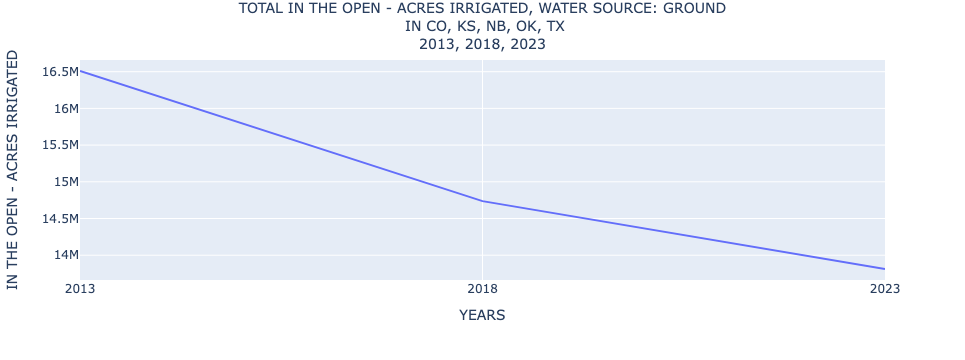

In [57]:
data={'year': test['year'], 'value': by_year_vals}

##Creating a line chart
fig = px.line(data, x="year", y="value")

fig.update_layout(
    title={'text': "TOTAL IN THE OPEN - ACRES IRRIGATED, WATER SOURCE: GROUND<br> IN CO, KS, NB, OK, TX<br>2013, 2018, 2023",
           'x':0.5,
           'y':0.965,
           'font': dict(size=14),
           'xanchor':'center'},
    xaxis_title='YEARS',
    yaxis_title=test['data_item'][0],
)
fig.show()

If you were wondering about that pesky case regarding domain=['TOTAL'], here's another quick demo to show you how it works. It is retrieving information about the number of operations in California in 2023 that use reclaimed water (defined by the USDA at https://tinyurl.com/5v78uapr as wastewater that has been treated for non-potable reuse purposes) from various sources.

In [86]:
pesky={'state_id':['CA']}

In [87]:
get_commodity()

array([['ENERGY'],
       ['FACILITIES & EQUIPMENT'],
       ['LABOR'],
       ['PRACTICES'],
       ['PUMPS'],
       ['WATER'],
       ['WELLS']], dtype=object)

In [88]:
pesky['commodity']=['WATER']

In [89]:
get_domains(pesky)

array([['TOTAL'],
       ['EXPENSE']], dtype=object)

In [90]:
pesky['domain']=['TOTAL']

In [91]:
get_data_items(pesky)

array([['RECYCLED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECYCLED, (FOR HORTICULTURE), UNDER PROTECTION - SQ FT IRRIGATED'],
       ['SOURCE = OFF FARM - EXPENSE, MEASURED IN $'],
       ['SOURCE = OFF FARM - EXPENSE, MEASURED IN $ / ACRE FOOT'],
       ['SOURCE = OFF FARM - EXPENSE, MEASURED IN $ / ACRE IRRIGATED'],
       ['SOURCE = OFF FARM - OPERATIONS WITH EXPENSE'],
       ['SOURCE = OFF FARM, SUPPLIER = NON-FEDERAL, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH WATER RECEIVED'],
       ['SOURCE = OFF FARM, SUPPLIER = NON-FEDERAL, IN THE OPEN - OPERATIONS WITH WATER RECEIVED'],
       ['SOURCE = OFF FARM - EXPENSE, MEASURED IN $ / 10,000 SQ FT IRRIGATED'],
       ['RECYCLED, IN THE OPEN - ACRES IRRIGATED'],
       ['RECYCLED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED - WATER APPLIED, MEASURED IN ACRE FEET'],
       ['RECLAIMED, IN THE OPEN - ACRES IRRIGATED'],
       ['RECLAIMED, IN THE OPEN - OPERATION

In [92]:
pesky['data_item']=['RECLAIMED, SOURCE = MUNICIPAL - OPERATIONS WITH AREA IRRIGATED']

In [93]:
get_domain_categories(pesky) 
#be sure to type in 'multiple' (but without the quotation marks) when prompted
##notice how we're only getting items with the same units of "operations with area irrigated"

multiple or one? multiple


array([['RECYCLED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECYCLED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = ON FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = INDUSTRIAL - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = OTHER - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = OFF FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED']],
      dtype=object)

In [94]:
pesky['data_item']+=['RECLAIMED, SOURCE = INDUSTRIAL - OPERATIONS WITH AREA IRRIGATED']

In [95]:
get_domain_categories(pesky)
#be sure to type in 'multiple' (but without the quotation marks) when prompted

multiple or one? multiple


array([['RECYCLED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECYCLED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = ON FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = OTHER - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = OFF FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED']],
      dtype=object)

In [96]:
pesky['data_item']+=['RECLAIMED, SOURCE = ON FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED']

In [97]:
get_domain_categories(pesky)
#be sure to type in 'multiple' (but without the quotation marks) when prompted

multiple or one? multiple


array([['RECYCLED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECYCLED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, IN THE OPEN - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, (FOR HORTICULTURE), UNDER PROTECTION - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = OTHER - OPERATIONS WITH AREA IRRIGATED'],
       ['RECLAIMED, SOURCE = OFF FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED']],
      dtype=object)

In [98]:
pesky['data_item']+=['RECLAIMED, SOURCE = OFF FARM ANIMAL OPERATION - OPERATIONS WITH AREA IRRIGATED']

In [99]:
get_years(pesky)

[['2013'], ['2018'], ['2023']]

In [100]:
pesky['year']=['2023']

In [101]:
#arbitrarily picking MAX as the aggregation method, but since we're only going to look at one particular
#year and one particular state, no matter the aggregation we will get the same values
max_query=final_query('MAX', pesky)

In [102]:
vals=execute_final_query(max_query, pesky)

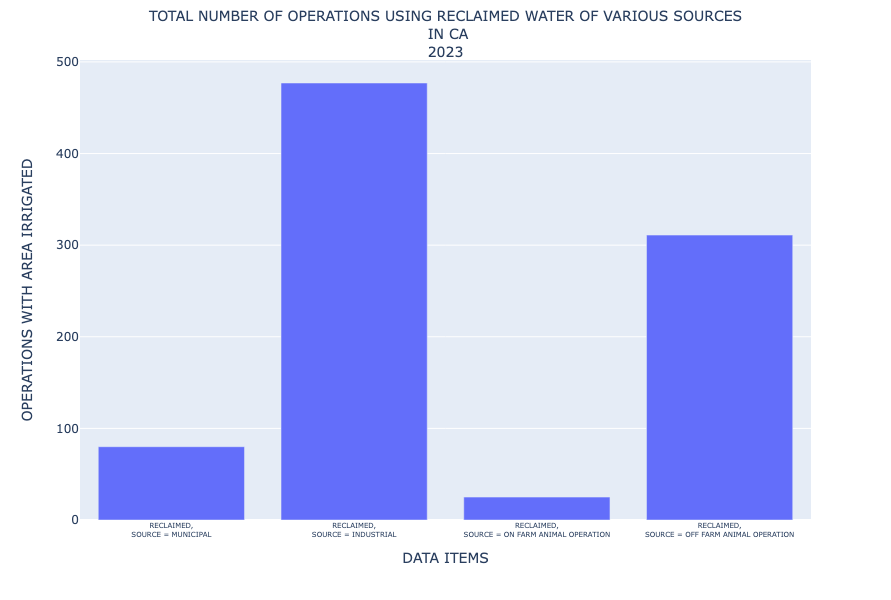

In [104]:
##Example visualization

x_labels=[]
for i in pesky['data_item']:
    initial=i.split(' - ')[0]
    split=initial.split(' ')
    new=split[0]+'<br>'+(' '.join(split[1:]))
    x_labels+=[new]  
    

data={'x': x_labels, 'y': vals}
fig = px.bar(data, x='x', y='y', width=800, height=600)


fig.update_layout(
    title={'text': "TOTAL NUMBER OF OPERATIONS USING RECLAIMED WATER OF VARIOUS SOURCES<br> IN CA<br>2023",
       'x':0.5,
       'y':0.965,
       'font': dict(size=14),
       'xanchor':'center'},
    xaxis_title='DATA ITEMS',
    yaxis_title=pesky['data_item'][0].split(' - ')[-1],
)
fig.update_layout(
xaxis = dict(
tickfont = dict(size=7),
tickangle=0))


fig.show()

In [106]:
conn.close()